In [41]:
import pandas as pd
from pymongo import MongoClient

In [42]:
# Set connection
client = MongoClient("mongodb://localhost:27017/")
db = client["bank"]
balances_collection = db["balances"]

# Load csv
accounts = pd.read_csv("sample/accounts.csv")
transactions = pd.read_csv("sample/transactions.csv", parse_dates=["tran_timestamp"])

In [43]:
print(transactions["tran_timestamp"].max())  # Should be 2018-12-21

2018-12-21 00:00:00+00:00


In [44]:
transactions["tx_type"].unique()

array(['TRANSFER'], dtype=object)

In [45]:
# Create root
balances = {}

OPEN_DATE_REFERENCE = "2017-01-01"  # Define the reference date
transactions['tran_timestamp'] = pd.to_datetime(transactions['tran_timestamp'])

# Take users data from account.csv
for _, row in accounts.iterrows():
    acc_id = row["acct_id"] # User id
    open_date = OPEN_DATE_REFERENCE if row["open_dt"] == 0 else row["open_dt"]
    initial_balance = round(float(row["initial_deposit"]), 2)

    balances[acc_id] = [{"date": open_date,
                         "balance": initial_balance
                        }]
    
    if acc_id == 0: # Check
        print("first user must be 0 => ",str(acc_id))
        print("user 0 initial deposit must be 96646.86 => ", initial_balance)

first user must be 0 =>  0
user 0 initial deposit must be 96646.86 =>  96646.86


In [46]:
print(len(transactions))

121457


In [47]:
balances[0][0]

{'date': '2017-01-01', 'balance': 96646.86}

In [48]:
# Apply transactions to users' balances
transactions.sort_values(by="tran_timestamp")

# Track the last balance for each account
current_balances = {acct_id: balances[acct_id][0]["balance"] for acct_id in balances}

for i, (_, row) in enumerate(transactions.iterrows()):
    # orig_acct = str(row["orig_acct"])
    # bene_acct = str(row["bene_acct"])
    orig_acct = row["orig_acct"]
    bene_acct = row["bene_acct"]
    amount = row["base_amt"]
    tx_type = row['tx_type']
    date = row["tran_timestamp"].strftime("%Y-%m-%d")

    if i == 0:
        print("first transaction must be from 982 to 23 => ", orig_acct, bene_acct)
    if i == 121456: # check that read till the last transaction
        print("\nlast transaction must be from 979 to 10 => ", orig_acct, bene_acct)

    if orig_acct in balances: # check that sender has a deposit
        last_balance = balances[orig_acct][-1]["balance"] # read balance from balances
        if tx_type in ['TRANSFER', 'WITHDRAWAL']: # all TRANSFER in the csv
            new_balance = last_balance - amount
        # elif tx_type == 'DEPOSIT':
        #    new_balance = last_balance + amount

        balances[orig_acct].append({"date": date, "balance": round(new_balance, 2)})
        if orig_acct == 0:
            print()
            print(row['tran_id'])
            print(f"on date {date} user {orig_acct} send to {bene_acct} {amount} dollars")
            print(f"user {orig_acct} balance goes from {last_balance} to {new_balance}")
            print(balances[orig_acct])
            
    
    if bene_acct in balances: # check that receiver has a deposit
        last_balance = balances[bene_acct][-1]["balance"]
        if tx_type in ['TRANSFER', 'DEPOSIT']:
            new_balance = last_balance + amount
        # elif tx_type == 'WITHDRAWAL':
        #     new_balance = last_balance - amount

        balances[bene_acct].append({"date": date, "balance": round(new_balance, 2)})
        if bene_acct == 0:
            print()
            print(row['tran_id'])
            print(f"on date {date} user {orig_acct} send to {bene_acct} {amount} dollars")
            print(f"user {bene_acct} balance goes from {last_balance} to {new_balance}")
            print(balances[bene_acct])
            

first transaction must be from 982 to 23 =>  982 23

445
on date 2017-01-02 user 0 send to 20 706.27 dollars
user 0 balance goes from 96646.86 to 95940.59
[{'date': '2017-01-01', 'balance': 96646.86}, {'date': '2017-01-02', 'balance': 95940.59}]

446
on date 2017-01-02 user 0 send to 19 473.31 dollars
user 0 balance goes from 95940.59 to 95467.28
[{'date': '2017-01-01', 'balance': 96646.86}, {'date': '2017-01-02', 'balance': 95940.59}, {'date': '2017-01-02', 'balance': 95467.28}]

673
on date 2017-01-03 user 0 send to 19 411.91 dollars
user 0 balance goes from 95467.28 to 95055.37
[{'date': '2017-01-01', 'balance': 96646.86}, {'date': '2017-01-02', 'balance': 95940.59}, {'date': '2017-01-02', 'balance': 95467.28}, {'date': '2017-01-03', 'balance': 95055.37}]

1974
on date 2017-01-09 user 0 send to 20 592.37 dollars
user 0 balance goes from 95055.37 to 94463.0
[{'date': '2017-01-01', 'balance': 96646.86}, {'date': '2017-01-02', 'balance': 95940.59}, {'date': '2017-01-02', 'balance': 954

In [52]:
balances[1]

[{'date': '2017-01-01', 'balance': 80707.36},
 {'date': '2017-01-04', 'balance': 80345.34},
 {'date': '2017-01-05', 'balance': 79735.0},
 {'date': '2017-01-11', 'balance': 79019.5},
 {'date': '2017-01-12', 'balance': 78875.82},
 {'date': '2017-01-12', 'balance': 79856.31},
 {'date': '2017-01-18', 'balance': 79141.41},
 {'date': '2017-01-19', 'balance': 78970.02},
 {'date': '2017-01-19', 'balance': 79523.44},
 {'date': '2017-01-23', 'balance': 79773.57},
 {'date': '2017-01-25', 'balance': 79099.97},
 {'date': '2017-01-26', 'balance': 78864.72},
 {'date': '2017-02-01', 'balance': 78505.18},
 {'date': '2017-02-02', 'balance': 78957.28},
 {'date': '2017-02-02', 'balance': 78235.8},
 {'date': '2017-02-08', 'balance': 77513.43},
 {'date': '2017-02-09', 'balance': 76817.64},
 {'date': '2017-02-09', 'balance': 77308.9},
 {'date': '2017-02-15', 'balance': 76587.1},
 {'date': '2017-02-16', 'balance': 76053.74},
 {'date': '2017-02-20', 'balance': 76285.81},
 {'date': '2017-02-22', 'balance': 7611

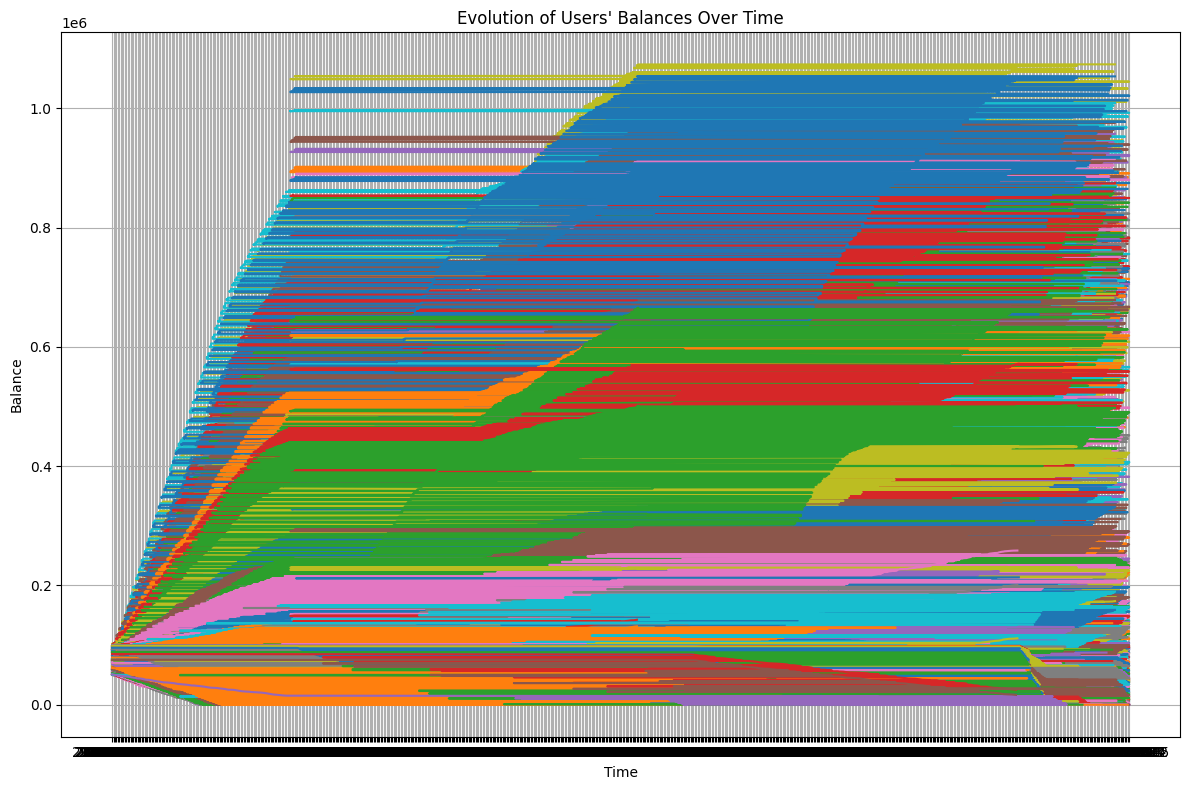

In [50]:
import matplotlib.pyplot as plt

# Plot the balance evolution for each account
plt.figure(figsize=(12, 8))
for acct_id, account_data in balances.items():
    dates = [entry["date"] for entry in account_data]
    balance_values = [entry["balance"] for entry in account_data]
    plt.plot(dates, balance_values, label=f'Account {acct_id}')

plt.title('Evolution of Users\' Balances Over Time')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
# Send the data to DB
for date in sorted(set(transactions["tran_timestamp"].dt.strftime("%Y-%m-%d"))):
    daily_balances = {
        "date": date,
        "balances": {
            str(user): {
                "balance": next((entry["balance"] for entry in reversed(b) if entry["date"] <= date), b[0]["balance"])
            } for user, b in balances.items()}
    }
    balances_collection.insert_one(daily_balances)

print("All balances are now updated in the DB with transactions from 2017-01-01 to 2018-12-21")

All balances are now updated in the DB with transactions from 2017-01-01 to 2018-12-21
